# Correlation

Find Pearson (maybe Spearman?) correlation between covid and library variabels

In [227]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as st
import numpy as np
import os

# Load data
library_path = "../Data/merged_library_covid_outer.csv"
df = pd.read_csv(library_path)
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,ADDRESS,CITY,ZIP,JANUARY,FEBRUARY,MARCH,APRIL,MAY,JUNE,JULY,AUGUST,SEPTEMBER,OCTOBER,NOVEMBER,DECEMBER,YTD,TYPE,YEAR,LAT,LNG
0,3401 W. Foster Ave.,Chicago,60625,8214.0,7614.0,8460.0,7414.0,7044.0,7970.0,9664.0,9069.0,7053.0,8012.0,6571.0,5924.0,93009.0,Circulation,2019,-87.701816,41.971155
1,13281 S. Corliss Ave.,Chicago,60827,378.0,326.0,332.0,270.0,320.0,325.0,354.0,229.0,234.0,377.0,369.0,500.0,4014.0,Circulation,2019,-87.633087,41.650765
2,5055 S. Archer Ave.,Chicago,60632,5365.0,5019.0,5417.0,5349.0,4833.0,4627.0,5356.0,4793.0,4537.0,5263.0,4051.0,3415.0,58025.0,Circulation,2019,-87.711251,41.810038
3,5615 W. Race Ave.,Chicago,60644,215.0,590.0,706.0,736.0,806.0,983.0,1134.0,1236.0,1193.0,1361.0,1286.0,1082.0,11328.0,Circulation,2019,-87.756863,41.881113
4,6100 W. Irving Park Rd.,Chicago,60634,9678.0,9764.0,10845.0,10541.0,9763.0,11442.0,11634.0,11063.0,9379.0,9932.0,8567.0,6492.0,119100.0,Circulation,2019,-87.797373,41.944967


# Cases and Circulation

### Isolate covid cases data and circulation data with corresponding years and zip codes

In [228]:
# Isolate circulation and cases data
circulation = df[df['TYPE'] == 'Circulation']
cases = df[df['TYPE'] == 'Cases']

# Subset for shared ZIPs
shared_zips =  list(set(circulation['ZIP']) & set(cases['ZIP']))
circulation = circulation[circulation['ZIP'].isin(shared_zips)]
cases = cases[cases['ZIP'].isin(shared_zips)]


# Subset for shared years
shared_years =  list(set(circulation['YEAR']) & set(cases['YEAR']))
circulation = circulation[circulation['YEAR'].isin(shared_years)]
cases = cases[cases['YEAR'].isin(shared_years)]

# Sort by year
cases = cases.sort_values(by = ['YEAR', 'ZIP'], axis = 0)
circulation = circulation.sort_values(by = ['YEAR', 'ZIP'], axis = 0)

# Average circulation data for each year and zip code combination
circulation_grouped = circulation.groupby(['YEAR', 'ZIP'])
circulation_avg = circulation_grouped[['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE', 'JULY',
                                       'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER']].mean()
circulation_avg = pd.DataFrame(circulation_avg)

### Generate scatter plot

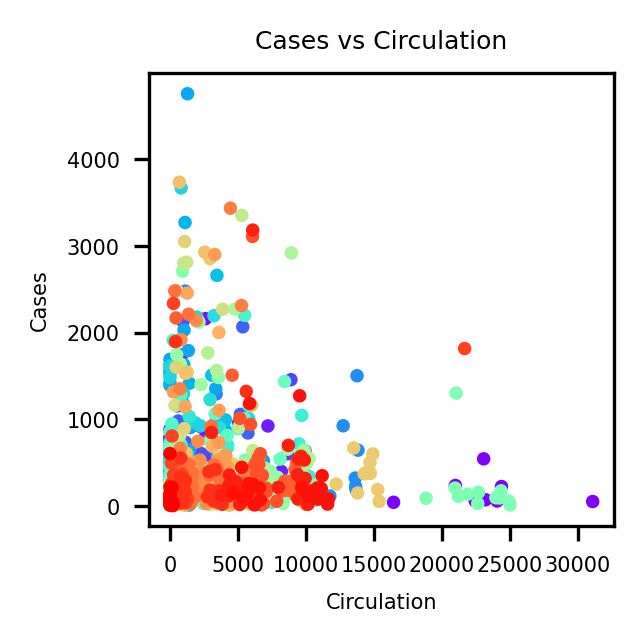

In [229]:
# Isolate monthly data of interest
monthly_cases = cases.loc[:,"JANUARY":"DECEMBER"]
monthly_circulation = circulation_avg

# Define color vector for each ZIP code
colors = cm.rainbow(np.linspace(0, 1, len(shared_zips)))
colors_hex = [matplotlib.colors.rgb2hex(color) for color in colors]
colors_rep = np.repeat(colors_hex, 24)

# Generate plot
fig, ax = plt.subplots()
plt.rcParams.update({'figure.figsize':(2,2), 'figure.dpi':300, 'font.size':5})
plt.scatter(monthly_circulation, monthly_cases, s = 5, c = colors_rep)
ax.set_title('Cases vs Circulation')
ax.set_xlabel('Circulation')
ax.set_ylabel('Cases')
plt.show()

In [230]:
# Export plot
plt.savefig('../Figures/cases_vs_circulation_scatter.png')

<Figure size 600x600 with 0 Axes>

### Calculate correlation

In [231]:
# Convert to numpy array and remove NaNs
circulation_array = np.array(monthly_circulation)
cases_array = np.array(monthly_cases)
circulation_clean = circulation_array[~np.isnan(cases_array)]
cases_clean = cases_array[~np.isnan(cases_array)]

# Calculate correlation coefficient
pearson_r = round(st.pearsonr(circulation_clean, cases_clean)[0], 3)
pearson_r

-0.039

# Deaths and Visitors

### Isolate covid deaths data and visitors data with corresponding years and zip codes

In [234]:
# Isolate circulation and cases data
visitors = df[df['TYPE'] == 'Visitors']
deaths = df[df['TYPE'] == 'Deaths']

# Subset for shared ZIPs
shared_zips =  list(set(visitors['ZIP']) & set(deaths['ZIP']))
visitors = visitors[visitors['ZIP'].isin(shared_zips)]
deaths = deaths[deaths['ZIP'].isin(shared_zips)]

# Subset for shared years
shared_years =  list(set(visitors['YEAR']) & set(deaths['YEAR']))
visitors = visitors[visitors['YEAR'].isin(shared_years)]
deaths = deaths[deaths['YEAR'].isin(shared_years)]

# Sort by year
deaths = deaths.sort_values(by = ['YEAR', 'ZIP'], axis = 0)
visitors = visitors.sort_values(by = ['YEAR', 'ZIP'], axis = 0)

# Average circulation data for each year and zip code combination
visitors_grouped = visitors.groupby(['YEAR', 'ZIP'])
visitors_avg = visitors_grouped[['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE', 'JULY',
                                       'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER']].mean()
visitors_avg = pd.DataFrame(visitors_avg)

### Generate scatter plot